# Rule Mining Results

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from utils.rule_comparison import get_rule_distribution_dataframe

# wn18rr dataset
#original_kb = np.loadtxt(config.wn18rr_dataset_path, dtype = 'object')
#relations = config.wn18rr_relations
folder_path = "./mined_rules/wn18rr_max_entities_1000/"

In [2]:
mined_rules_parameters = pd.read_pickle(folder_path + "mined_rules_parameters.pkl")
parameter_combinations = pd.read_pickle(folder_path + "parameter_combinations.pkl")
extension_sizes = pd.read_pickle(folder_path + "extension_sizes.pkl")
extension_sizes['Candidate_criteria'] =  extension_sizes.Candidate_criteria.astype(str)
original_rules = pd.read_pickle(folder_path + "original_rules.pkl")

# add bool to indicate whether rule is an original rule or not
is_original_rule = mined_rules_parameters['Rule'].isin(original_rules['Rule'].values)
mined_rules_parameters['Original_rule'] = is_original_rule

In [3]:
print("There are " + str(len(parameter_combinations)) + " parameter combinations. This means that there are " + str(len(parameter_combinations)) + " different KG extensions.")

There are 48 parameter combinations. This means that there are 48 different KG extensions.


In [4]:
print(str(len(original_rules)) + " rules were mined from the original KG.") 
kg_embedding_rules = mined_rules_parameters.loc[((mined_rules_parameters["Model"] == "ComplEx") | (mined_rules_parameters["Model"] == "DistMult")| (mined_rules_parameters["Model"] == "TransE") | (mined_rules_parameters["Model"] == "RandomBaseline") )]
print("On the many different KG extensions, rules were mined " + str(len(kg_embedding_rules)) + " times. Out of these there were found " + str(len(kg_embedding_rules.drop_duplicates("Rule"))) + " unique rules.")

10 rules were mined from the original KG.
On the many different KG extensions, rules were mined 7953 times. Out of these there were found 830 unique rules.


In [5]:
rule_count_df = kg_embedding_rules.groupby(['Model', 'Entity_selection', 'Candidate_criteria', 'Original_rule']).size().to_frame('Freq')
rule_count_df = rule_count_df.reset_index(drop=False)
rule_count_df = rule_count_df.pivot_table('Freq',['Model', 'Entity_selection', 'Candidate_criteria'], 'Original_rule')
rule_count_df = rule_count_df.reset_index(drop=False)

In [6]:
rule_count_df[False] = rule_count_df[False].fillna(0)
rule_count_df[True] = rule_count_df[True].fillna(0)
rule_count_df['Index'] = rule_count_df['Model'] + ", " +  rule_count_df['Entity_selection'] + ", " + rule_count_df['Candidate_criteria']

We would like to examine the mined rules, but since many rules are mined from different datasets the confidence measurements for the same rule will differ based on what dataset it calculated on. To solve this issue we will first look at the effects of parameter combinations, and then choose the "best" KG extension for us to focus on examining the rules mined from it. We will start by looking at the number of rules mined per KG extension and the mean PCA condifence of those mined rules.

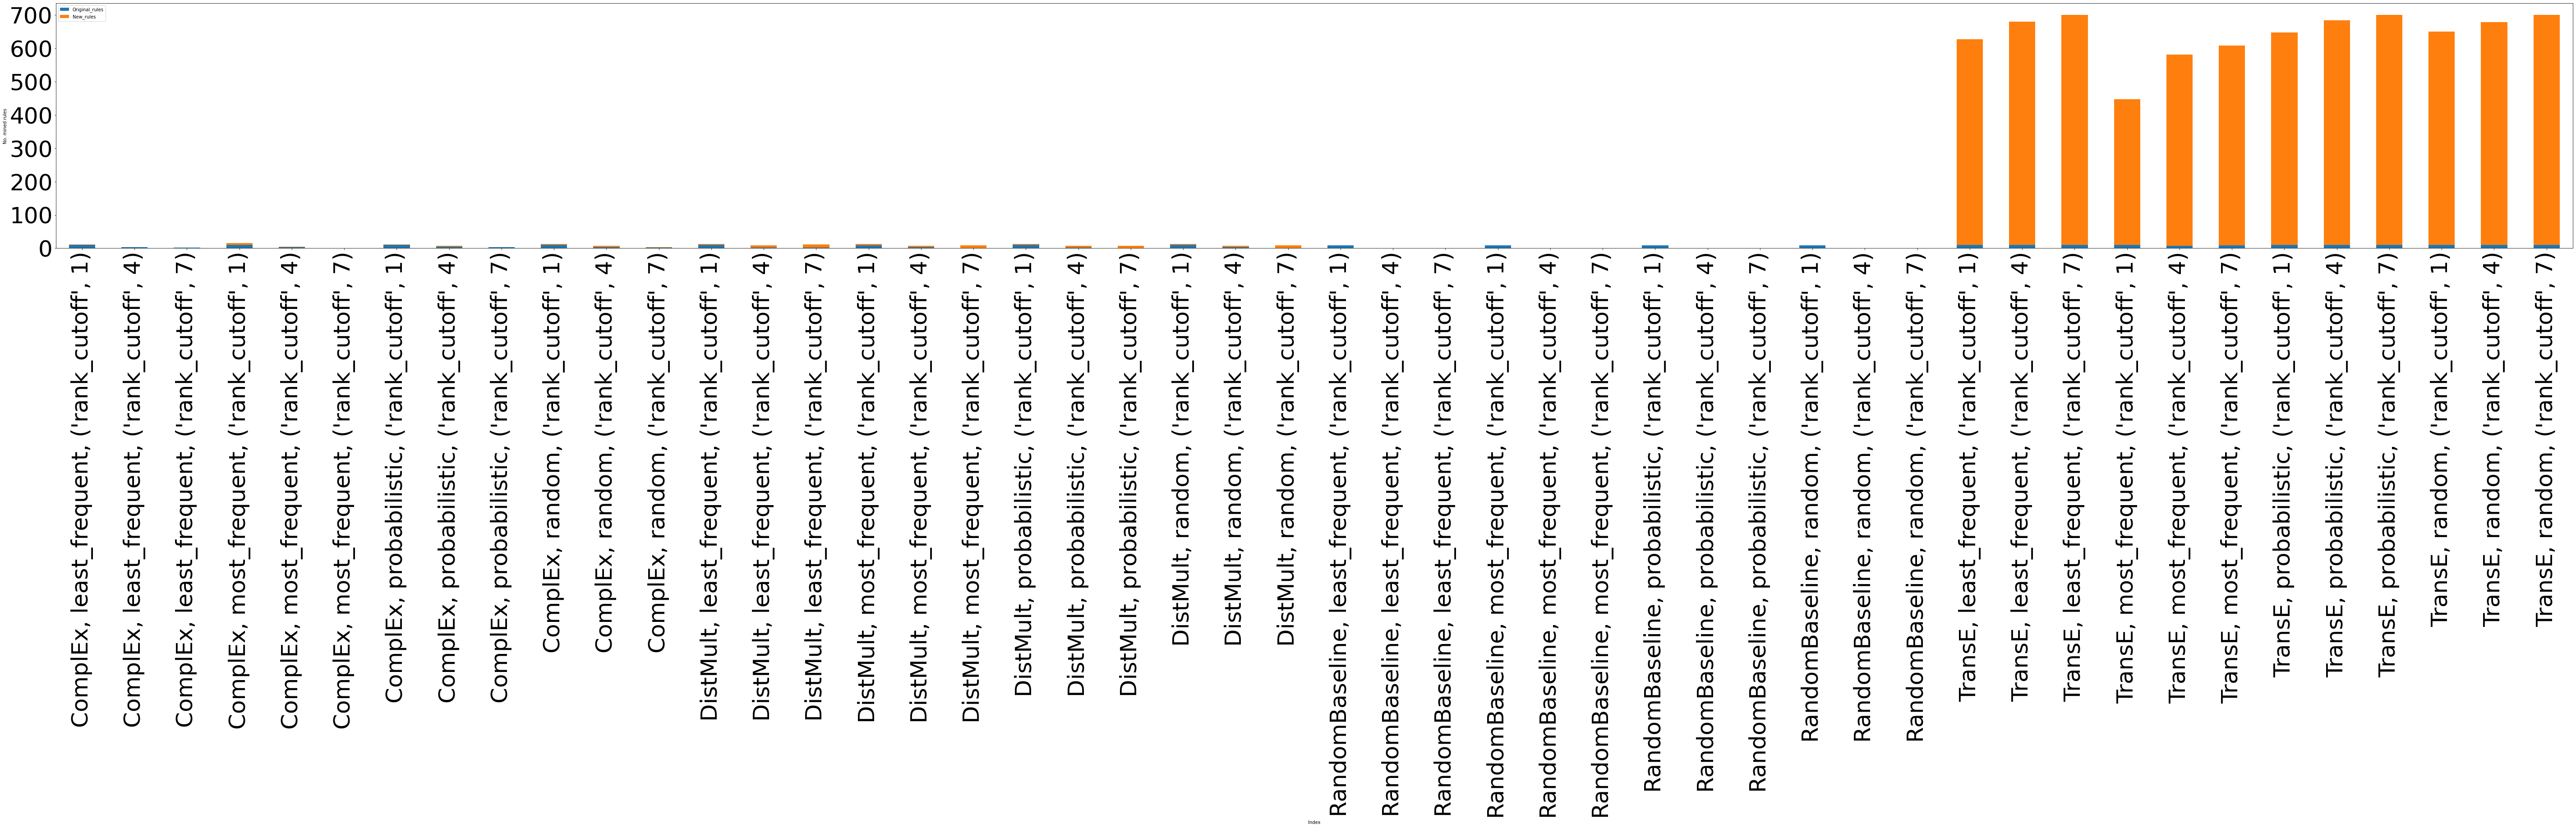

In [7]:
plot_df = pd.DataFrame({'Original_rules': rule_count_df[True].values, 'New_rules': rule_count_df[False].values}, index=rule_count_df.Index)
fig = plot_df.plot(kind = "bar", figsize = (100, 10), ylabel = "No. mined rules", stacked = True, fontsize = 50).get_figure()

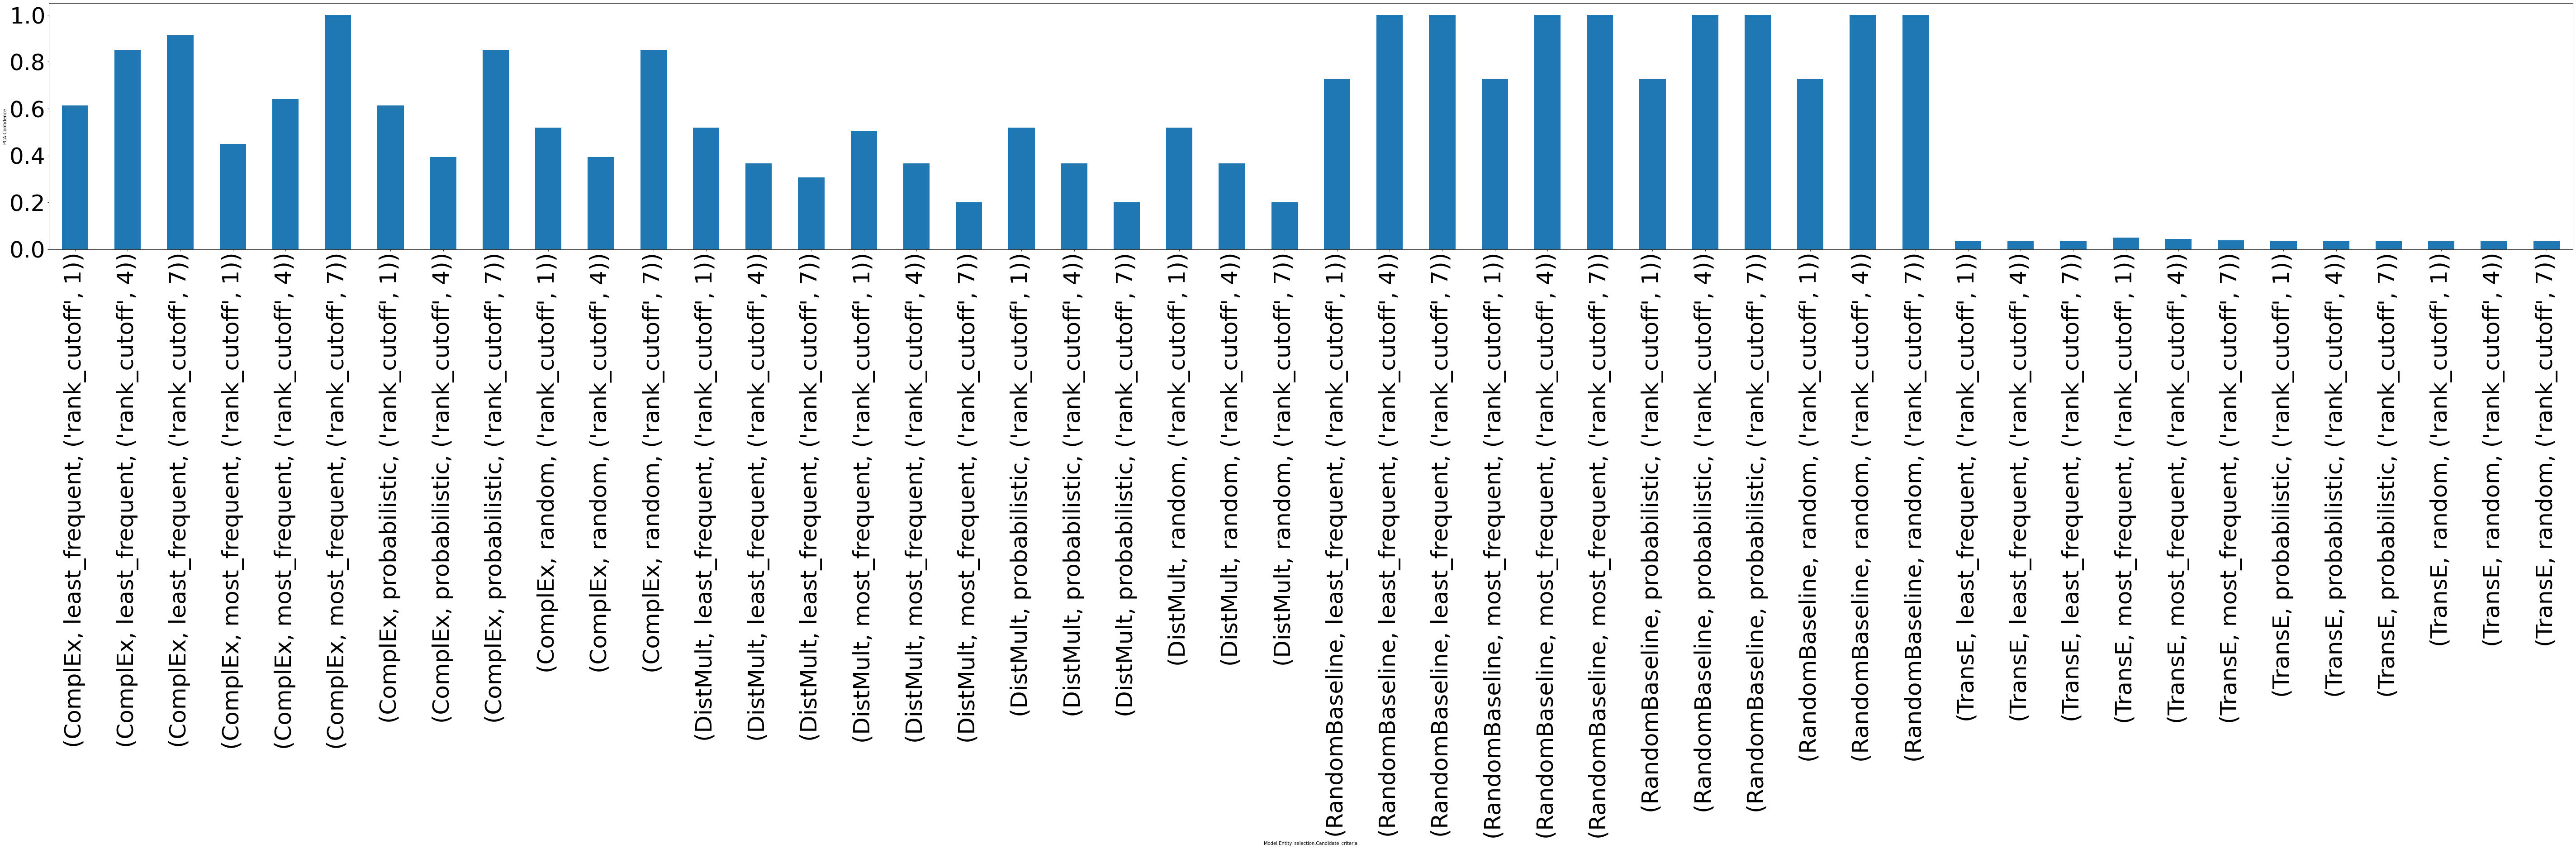

In [8]:
fig = kg_embedding_rules.groupby(['Model', 'Entity_selection', 'Candidate_criteria'])['PCA Confidence'].mean().plot(kind = "bar", figsize = (100, 10), ylabel = "PCA Confidence", fontsize = 50).get_figure()
#fig.savefig("Mean_PCA_all_combinations", bbox_inches="tight")

<AxesSubplot:xlabel='Model', ylabel='No. mined rules'>

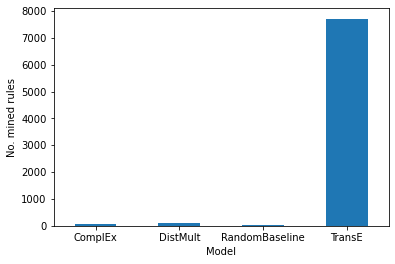

In [9]:
kg_embedding_rules.groupby(['Model']).size().plot(kind = "bar", rot=0, ylabel = "No. mined rules", fontsize = 10)

We can see that the use of TransE to expand the KG results in tenfold as many rules being mined, and that the mean PCA confidence for those rule sets is much lower than the other rule sets. Upon further examination of the TransE emdedding model we can see that all the embeddings for the relations have values that tend toward zero. Based on this and the poor confidence in the many rules mined with a TransE-extension, we will drop this model from further data analysis.

In [10]:
kg_embedding_rules = kg_embedding_rules.loc[kg_embedding_rules["Model"] != "TransE"]
rule_count_df = rule_count_df.loc[rule_count_df["Model"] != "TransE"]
extension_sizes = extension_sizes.loc[extension_sizes["Model"] != "TransE"]

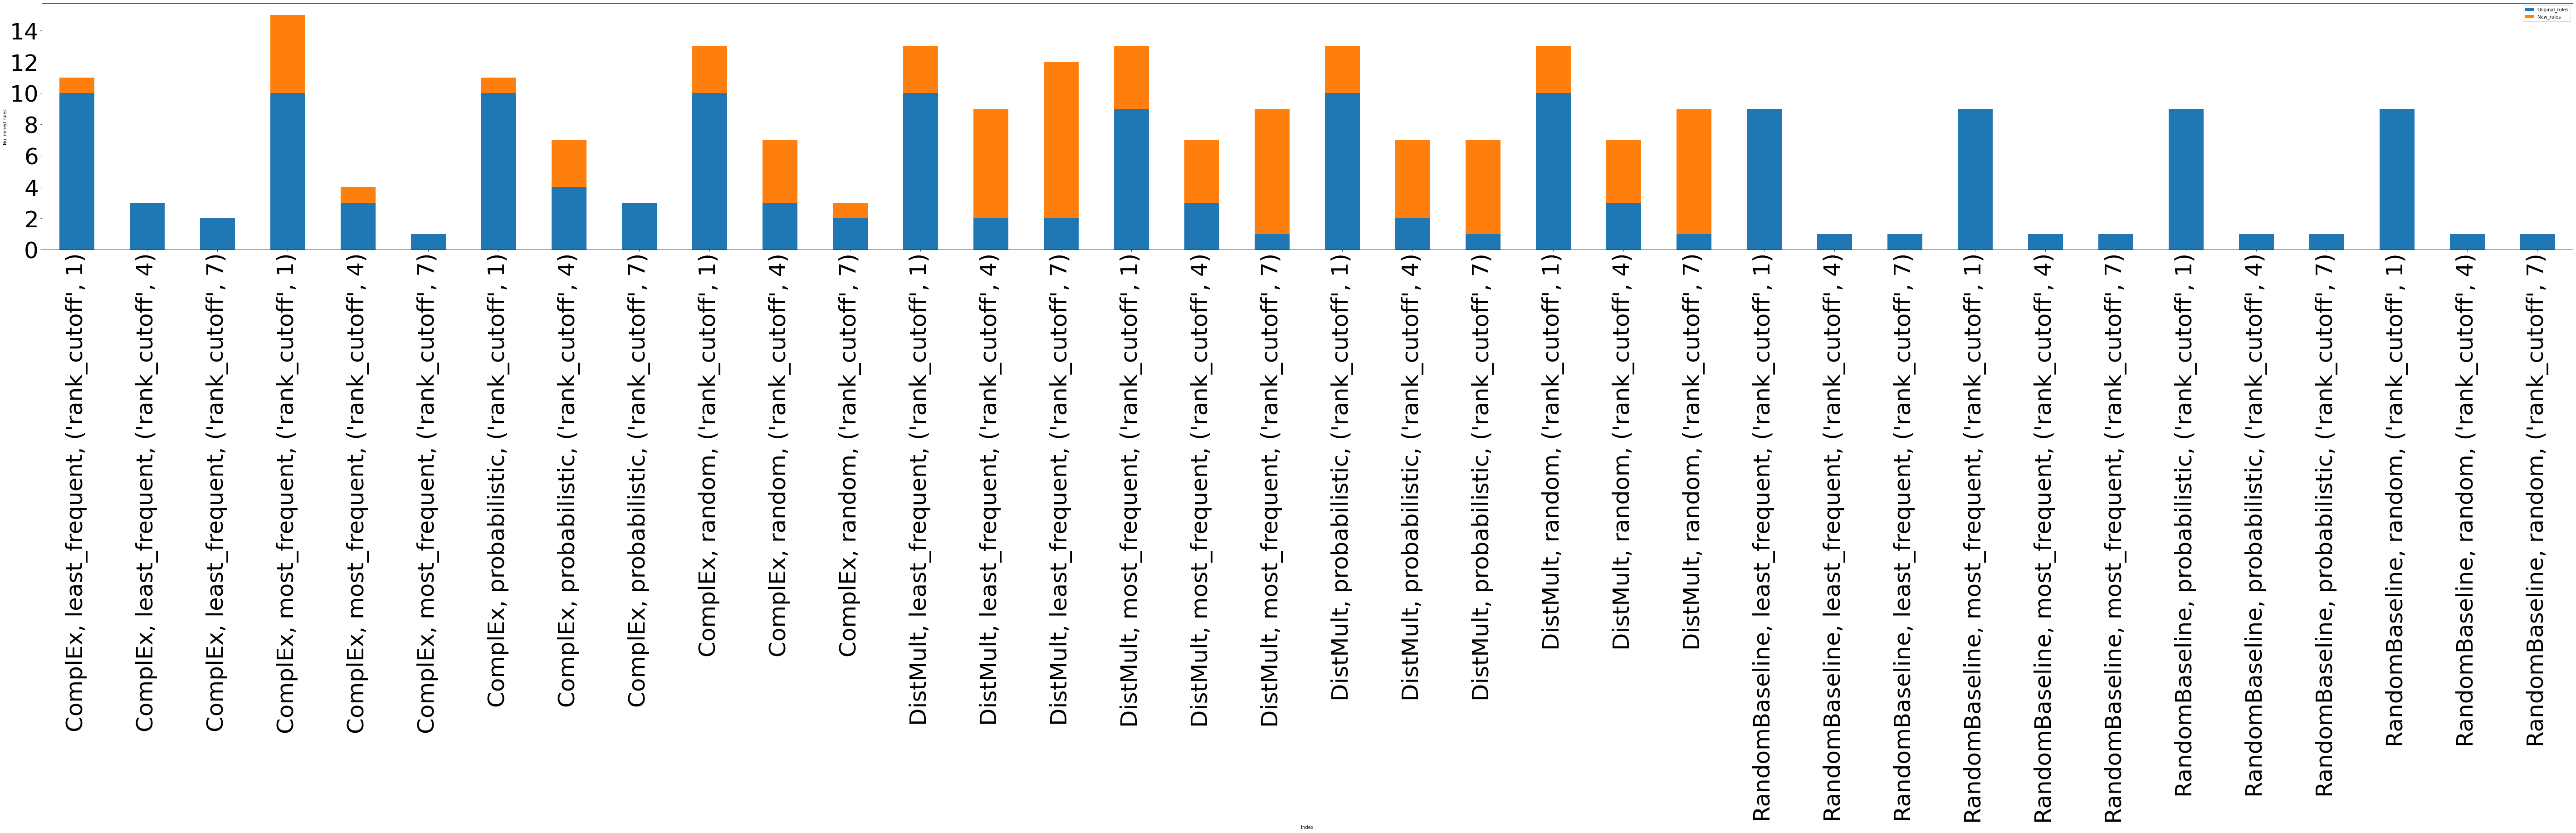

In [11]:
plot_df = pd.DataFrame({'Original_rules': rule_count_df[True].values, 'New_rules': rule_count_df[False].values}, index=rule_count_df.Index)
fig = plot_df.plot(kind = "bar", figsize = (100, 10), ylabel = "No. mined rules", stacked = True, fontsize = 50).get_figure()

We can see now that there aren't that many instances where all the original rules were mined. None of the KGs extended with the use of the RandomBaseline managed to produce all the original rules. From the two remaining models, only the times were rank cutoff 1 was used all original rules were mined. So, we will remove all datapoints created with the RandomBaseline and rank cutoff that is not 1.

In [12]:
kg_embedding_rules = kg_embedding_rules.loc[(kg_embedding_rules["Model"] != "RandomBaseline") & (kg_embedding_rules["Candidate_criteria"] == "('rank_cutoff', 1)")]
rule_count_df = rule_count_df.loc[(rule_count_df["Model"] != "RandomBaseline") & (rule_count_df["Candidate_criteria"] == "('rank_cutoff', 1)")]
extension_sizes = extension_sizes.loc[(extension_sizes["Model"] != "RandomBaseline") & (extension_sizes["Candidate_criteria"] == "('rank_cutoff', 1)")]

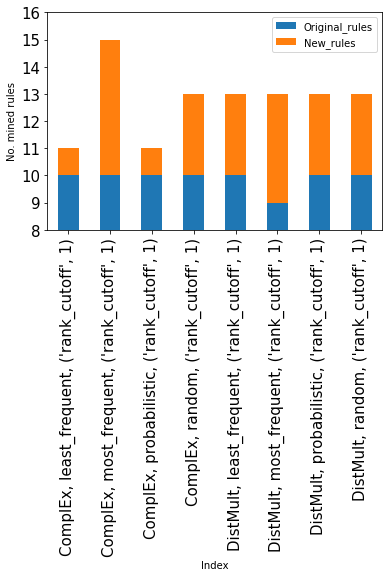

In [13]:
plot_df = pd.DataFrame({'Original_rules': rule_count_df[True].values, 'New_rules': rule_count_df[False].values}, index=rule_count_df.Index)
fig = plot_df.plot(kind = "bar", ylabel = "No. mined rules", stacked = True, ylim = (8, 16), fontsize = 15).get_figure()

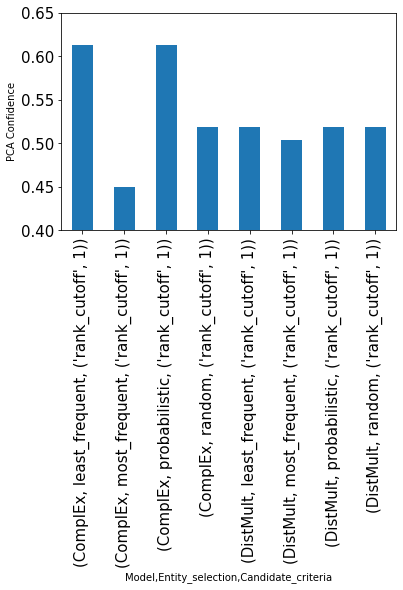

In [14]:
fig = kg_embedding_rules.groupby(['Model', 'Entity_selection', 'Candidate_criteria'])['PCA Confidence'].mean().plot(kind = "bar", ylim = (0.4, 0.65), ylabel = "PCA Confidence", fontsize = 15).get_figure()

At this point we can see that **Complex, most_frequent, ('rank_cutoff', 1)** has mined the most additional rules, but also has the lowest PCA confidence of the remaining sets. **Complex, random, ('rank_cutoff', 1)** and all remaining DistMults, apart from **DistMult, most_frequent, ('rank_cutoff', 1)** mined all the original rules in addition to two extra rules. So the choice is between these remaining four.

<AxesSubplot:xlabel='Model,Entity_selection,Candidate_criteria', ylabel='KG extension size'>

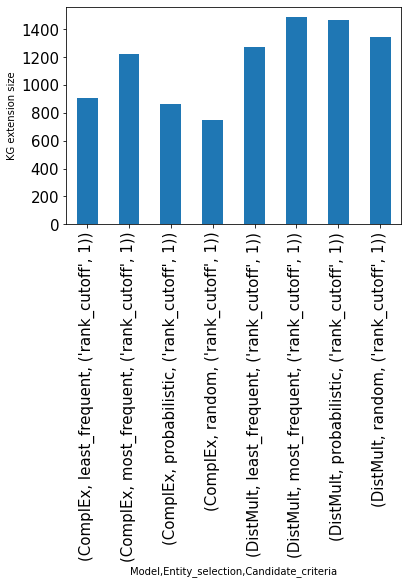

In [15]:
extension_sizes.groupby(['Model', 'Entity_selection', 'Candidate_criteria'])['Extension'].mean().plot(kind = "bar", rot=90, ylabel = "KG extension size", fontsize = 15)

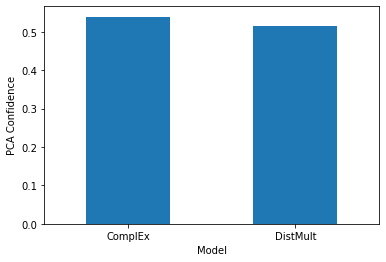

In [16]:
fig = kg_embedding_rules.groupby(['Model'])['PCA Confidence'].mean().plot(kind = "bar", ylabel = "PCA Confidence", fontsize = 10, rot = 0).get_figure()

<AxesSubplot:xlabel='Model', ylabel='Mean KG extension size'>

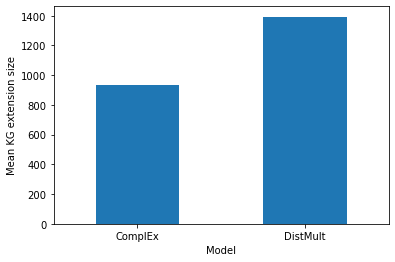

In [17]:
extension_sizes.groupby(['Model'])['Extension'].mean().plot(kind = "bar", rot=0, ylabel = "Mean KG extension size", fontsize = 10)

If we look at the extension sizes of the remaining sets we see that DistMult has extended the KG by more new facts than ComplEx has. ComplEx seems to be a more strict model than DistMult as it has ranked candidate triples lower. The KG extensions of ComplEx are smaller and fewer rules are mined from these extended KGs. ComplEx also seems to result in slightly higher mean PCA confidence for rules mined, but this could be attributed to the fact that there are fewer rules to be measuresd in the ComplEx case. This means that a greater part of PCA confidence measures will be of rules mined from the original dataset, resulting in a higher mean PCA confidence.

Since the experiment conducted was limited by the number of candidate triples that were considered, one could argue that if the candidate size was increased then a more strict model would be most beneficial. Only the best canidates would be added, and it would still be a relatively large KG extension due to the sheer number of candidates that were considered.

Therefore we will select **Complex, most_frequent, ('rank_cutoff', 1)** as the rule set to focus on.